# Replication of the two-asset model in Auclert, Rognile and Straub  (2020)* without sticky information.

*Auclert, Adrien, Matthew Rognlie, and Ludwig Straub. Micro jumps, macro humps: Monetary policy and business cycles in an estimated HANK model. No. w26647. National Bureau of Economic Research, 2020.

This notebook serves as an enviroment to replicate the model but also to get accustomed to the code package and the solution alogorithms.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from tabulate import tabulate
import pandas as pd

from HANKStickyModel import HANKStickyModelClass

# Replication settings

In [2]:
import os
from types import SimpleNamespace

replication_settings = {
    'savefolder': os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models'),   # if empty, the usual "saved" folder is used
    'update_par': {     # updates par for all models
    },
    # specify the replications to be carried out in the notebook
    'do_replicate':{
        'different_dbeg': False,  # test if different initial distribution lead to the same ss.D
        'plot_em': True,          # plot IRFs of baseline model with a monetary policy shock
        'do_sticky': False,        # run the model with sticky information
        'compare_tax_debt': False # compare IRFs for debt and tax financing
    },
}

# update parameters for
updated_par=replication_settings['update_par']

# Model specification
The model has the following key features:
 - incomplete markets
 - two assets
 - sitcky wages and prices
 - capital and investment adjustment costs
 - long-term government debt

In contrast to the original model I will leave out the following:
- sticky information
- permanent heterogeneity

The DAG of the model used in the original paper is:
<img src="images\\DAG_Humps.png" alt="DAG Humps, Jumps" width=800 height=600 />
For the fiscal policy shock extension, there would be an additional arrow to the "fiscal" bubble.

In [3]:
model = HANKStickyModelClass(name='baseline', par=updated_par, savefolder=replication_settings['savefolder'])

# 1. Find Steady State

In [4]:
model.find_ss(do_print=True)

Find optimal beta for market clearing
final evaluation
household problem in ss solved in 0.4 secs [219 iterations]
household problem in ss simulated in 0.1 secs [239 iterations]
steady state found in 13.8 secs
 beta   = 0.9576
 nu     = 1.1844
Discrepancy in C =   0.00000000
Discrepancy in L =   0.00000000
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000


In [6]:
par = model.par
ss = model.ss
#
# print(par.A_Y_ratio)
# print(ss.p_eq + ss.qB - ss.L)
# np.isclose(ss.p_eq + ss.qB - ss.L, par.A_Y_ratio*ss.Y)

In [7]:
# is the error in market clearing due to numerical errors?
print("Error in cash on hand:")
# cash-on-hand
M = (1+ss.rl) * ss.L + ss.Z + ss.ra * par.A_target

# compare to results derived from distribution * grid
m1, m2, m3 = np.meshgrid((1 + ss.rl) * par.l_grid, ss.Z * par.z_grid, ss.ra * par.a_grid)
m_grid = (m1 + m2 + m3).reshape(1, par.Nz, par.Nl, par.Na).repeat(par.Nfix, 0)
t1 = M - np.sum(ss.D * m_grid)
print(f"Error in m_grid * ss.D: {t1}")
print(f"Error in clearing_C: {ss.clearing_C}")
print(f"Diff: {t1 + ss.clearing_C}")

# or
m_grid = np.empty((par.Nfix, par.Nz, par.Nl, par.Na))
for i_b in range(par.Nfix):
    for i_z in range(par.Nz):
        for i_l in range(par.Nl):
            for i_a in range(par.Na):
                m_grid[i_b, i_z, i_l, i_a] = (1 + ss.rl) * par.l_grid[i_l] + ss.Z * par.z_grid[i_z] + ss.ra * par.a_grid[i_a]
t2 = M - np.sum(ss.D * m_grid)
print(t2 - ss.clearing_Y)

Error in cash on hand:
Error in m_grid * ss.D: -7.212008767965017e-12
Error in clearing_C: 7.212230812569942e-12
Diff: 2.220446049250313e-16
0.0


In [8]:
# Where is the error in the steps that lead to the market clearing equation?

print(f"Clearing of illiquid asset constraint {ss.clearing_A}")
# da = ss.ra * ss.A
a_grid = (par.a_grid).reshape(1,1,1,par.Na).repeat(par.Nl,2).repeat(par.Nz,1).repeat(par.Nfix,0)
da_grid = a_grid * ss.ra
print(f"Diff in da: {np.sum(da_grid * ss.D) - ss.ra * ss.A}")

Clearing of illiquid asset constraint 5.5067062021407764e-14
Diff in da: 6.938893903907228e-16


In [9]:
print(model.ss.L_hh)
print(model.ss.A_hh)

0.23000000000000004
7.072344549984053


The household simulation takes quite a while if the distribution also needs to adjust along the illiquid asset grid, because the parameter $\chi$ is quite small.
Therefore, it saves time to run the simulation with an initial distribution that is already optimized aling the illiquid asset grid. This part of the distribution is analylically available as all households hold the same targat value of illiquid assets in the steady state. This target is given as the amount of illiquid assets in the steady state as the population mass is 1.

In [10]:
# show that starting at the optimized distribution leads to the same result
if replication_settings['do_replicate']['different_dbeg']:
    par_diff_init_distr = replication_settings['update_par'].copy()
    par_diff_init_distr['start_dbeg_opti'] = not par_diff_init_distr['start_dbeg_opti']
    model_diff_init_distr = HANKStickyModelClass(name='baseline', par=par_diff_init_distr)
    model_diff_init_distr.find_ss(do_print=True)
    diff_D = abs(model.ss.D - model_diff_init_distr.ss.D)
    print(f'Absolute difference in the simulated distributions is {np.sum(diff_D):.10f}')

## Productivity States

In [11]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [12]:
# steady state distribution for productivity states
for i_fix in range(par.Nfix):

    beta = par.beta_grid[i_fix]
    print(f'{beta = :.4f}:')

    for z,pr_z in zip(par.z_grid,ss.Dz[i_fix]/np.sum(ss.Dz[i_fix])):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print(f'Sum(Pr[z]) = {ss.Dz.sum():.4f}')

beta = 0.9576:
 Pr[z = 0.2595] = 0.0156
 Pr[z = 0.3904] = 0.0938
 Pr[z = 0.5872] = 0.2344
 Pr[z = 0.8833] = 0.3125
 Pr[z = 1.3286] = 0.2344
 Pr[z = 1.9984] = 0.0938
 Pr[z = 3.0060] = 0.0156
Sum(Pr[z]) = 1.0000


In [13]:
# transition probabilites between states
for i_fix in range(par.Nfix):
    tab = np.concatenate((ss.z_trans[i_fix], ss.z_trans[i_fix,:,:].sum(axis=1).reshape(-1,1)), axis=1)
    header = [""] * par.Nz + ["sum"]
    table = tabulate(tab.round(3), tablefmt='simple', headers=header)
    print(table)

                                                   sum
-----  -----  -----  -----  -----  -----  -----  -----
0.902  0.094  0.004  0      0      0      0          1
0.016  0.904  0.078  0.003  0      0      0          1
0      0.031  0.904  0.062  0.002  0      0          1
0      0.001  0.047  0.905  0.047  0.001  0          1
0      0      0.002  0.062  0.904  0.031  0          1
0      0      0      0.003  0.078  0.904  0.016      1
0      0      0      0      0.004  0.094  0.902      1


## Policy functions

In [14]:
c = ss.c[0,:,:,:]
l = ss.l[0,:,:,:]
a = ss.a[0,:,:,:]

### Consumption and savings function at different illiquid asset grids

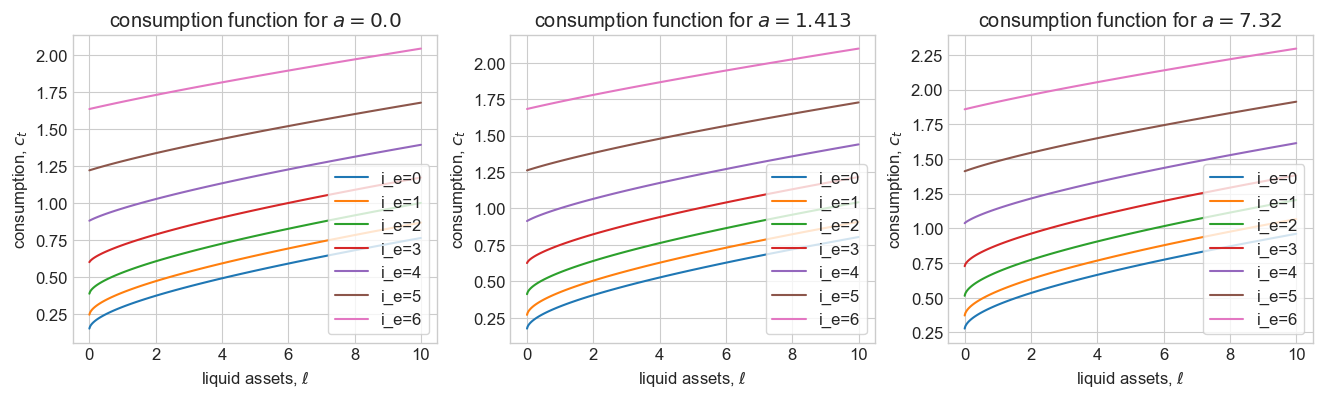

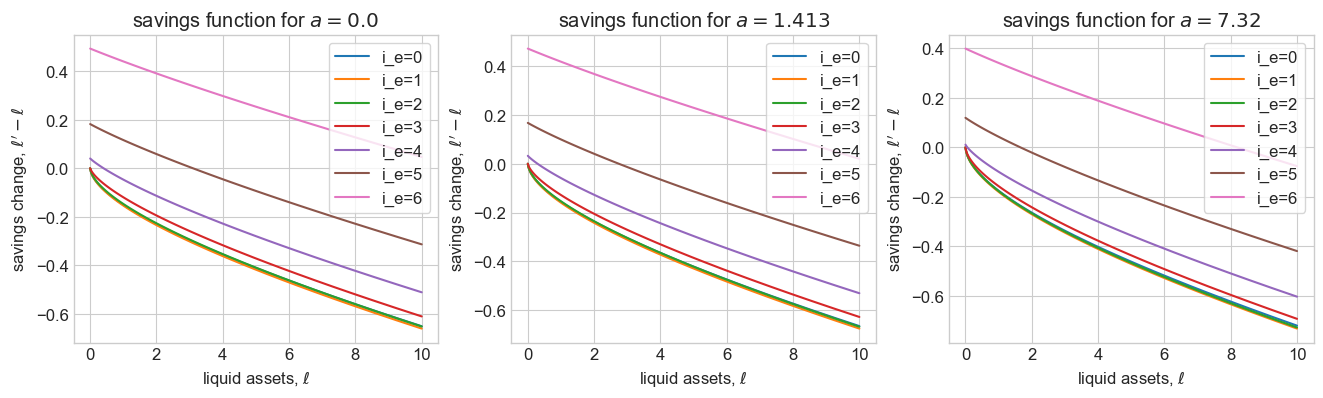

In [15]:
fig = plt.figure(figsize=(16,4),dpi=100)
a_points = [0,int(0.5*par.Na),int(0.9*par.Na)]
for i,i_a in enumerate(a_points):
    a_i = par.a_grid[i_a]
    ax = fig.add_subplot(1,len(a_points),i+1)
    ax.set_title(f'consumption function for $a = {a_i:.4}$')
    for i_e in range(par.Nz):
        ax.plot(par.l_grid, c[i_e,:,i_a], label=f'i_e={i_e}')
    ax.legend(frameon=True)
    ax.set_xlabel('liquid assets, $\ell$')
    ax.set_ylabel('consumption, $c_t$')

fig = plt.figure(figsize=(16,4),dpi=100)
for i,i_a in enumerate(a_points):
    a_i = par.a_grid[i_a]
    ax = fig.add_subplot(1,len(a_points),i+1)
    ax.set_title(f'savings function for $a = {a_i:.4}$')
    for i_e in range(par.Nz):
        ax.plot(par.l_grid, l[i_e,:,i_a]-par.l_grid, label=f'i_e={i_e}')
    ax.legend(frameon=True)
    ax.set_xlabel('liquid assets, $\ell$')
    ax.set_ylabel('savings change, $\ell\'-\ell$')

### Policy function at the steady state

Text(0, 0.5, "savings change, $\\ell'-\\ell$")

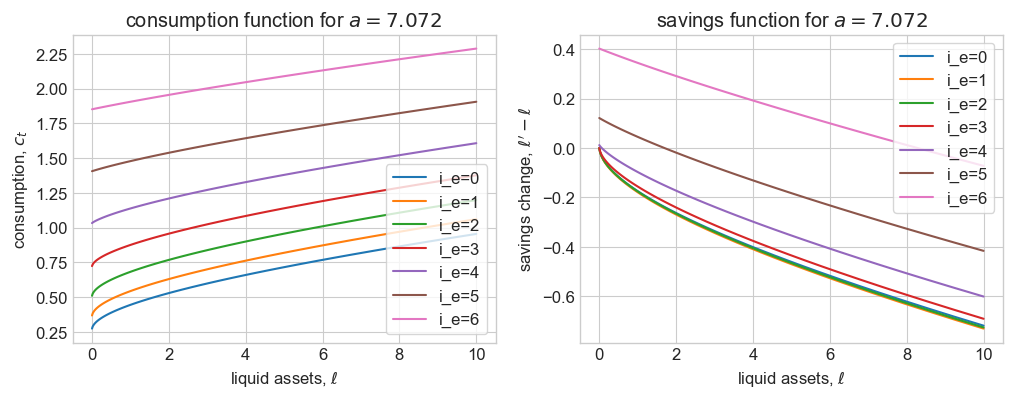

In [16]:
# find closest but smaller grid value to target
i_a_target = np.abs(par.a_grid-ss.A).argmin() # find grid value which is closest to the target
if par.a_grid[i_a_target] > ss.A:
    i_a_target += -1 # select grid value that is smaller than target
assert i_a_target <= par.Na, 'illiquid asset target outside of grid'
# find weights between grid value and target,
    # s.t. w*a_grid[i]+(1-w)*a_grid[i+1] = a_target
i_a_weight = (ss.A-par.a_grid[i_a_target+1]) / (par.a_grid[i_a_target]-par.a_grid[i_a_target+1])

fig = plt.figure(figsize=(12,4),dpi=100)

ax = fig.add_subplot(1,2,1)
ax.set_title(f'consumption function for $a = {ss.A:.4}$')
for i_e in range(par.Nz):
    c1 = c[i_e,:,i_a_target]
    c2 = c[i_e,:,i_a_target+1]
    c_a_ss = i_a_weight*c1 + (1-i_a_weight)*c2
    ax.plot(par.l_grid, c_a_ss, label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('consumption, $c_t$')

ax = fig.add_subplot(1,2,2)
ax.set_title(f'savings function for $a = {ss.A:.4}$')
for i_e in range(par.Nz):
    l1 = l[i_e,:,i_a_target]
    l2 = l[i_e,:,i_a_target+1]
    l_a_ss = i_a_weight*l1 + (1-i_a_weight)*l2
    ax.plot(par.l_grid, l_a_ss-par.l_grid, label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('savings change, $\ell\'-\ell$')

### Policy function for illiquid assets
The policy function for illiquid asset gives next periods illiquid assets given the interest rate for illiquid assets (steady state and contemporaneous), the illiquid asset target and the illiquid asset state.
It is independent of the other state and choice variables.

In [17]:
# check that pol. function for a is independent of c, l and s
for i_z in range(par.Nz-1):
    assert np.sum(a[i_z] - a[i_z+1]) == 0.0, 'policy function for illiquid assets changes with z'
for i_l in range(par.Nl-1):
    assert np.sum(a[:, i_l, :] - a[:, i_l+1, :]) == 0.0, 'policy function for illiquid assets changes with l'

Change in illiquid assets given different states of illiquid assets.
In other words: how does the households redistribute given they are at different grids for the illiquid asset.

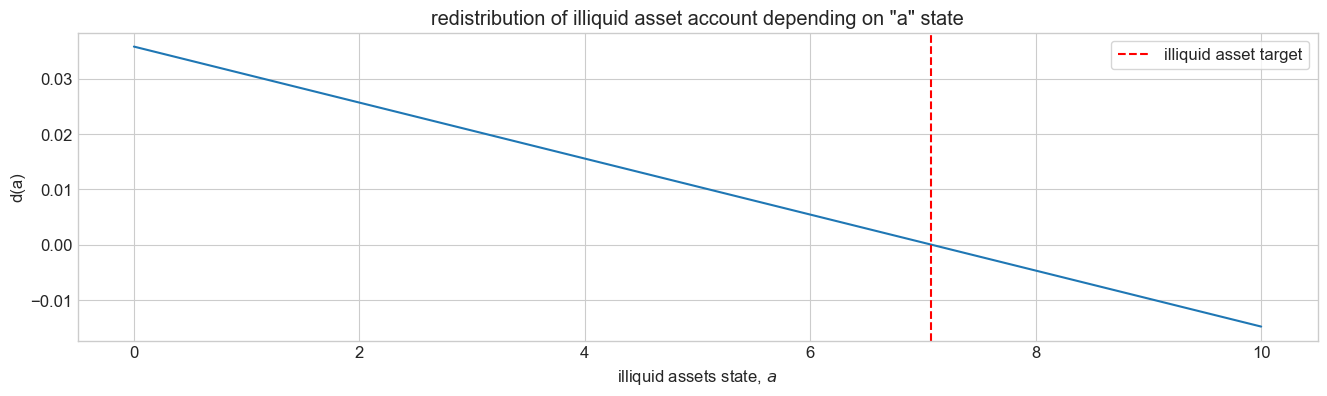

In [18]:
# plot change in illiquid assets
A_target = par.A_target
fig = plt.figure(figsize=(16,4),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title(f'redistribution of illiquid asset account depending on "a" state')
ax.plot(par.a_grid, a[0,0,:]-par.a_grid)
ax.axvline(x=A_target, color='red', linestyle='--', label='illiquid asset target')
ax.set_xlabel(f'illiquid assets state, $a$')
ax.set_ylabel(f'd(a)')
ax.legend(frameon=True)

Change in illiquid assets given different states of illiquid asset interest rates.
In other words: how does the households redistribute given the interest rate on the illiquid assets differs from the steady state value.

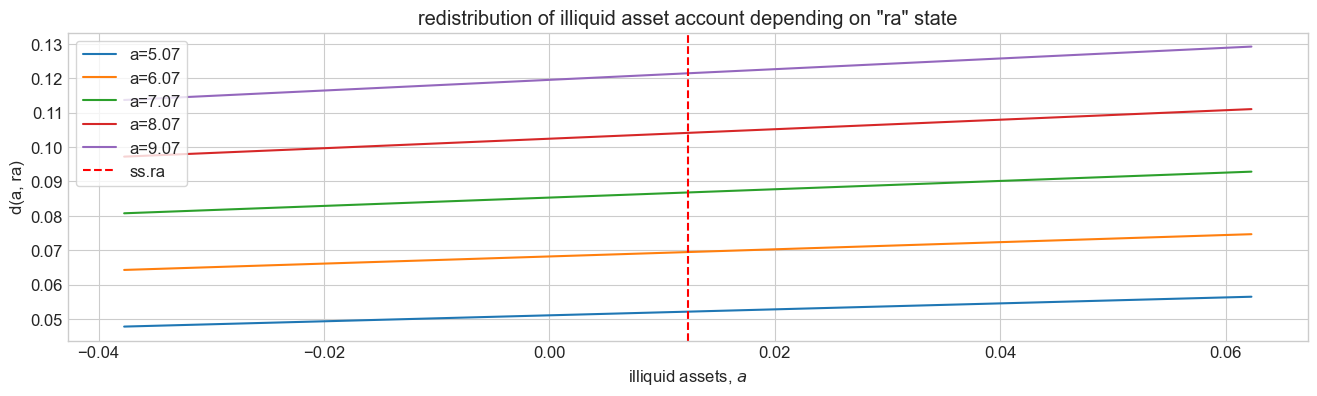

In [19]:
da = lambda a, ra: ss.r / (1 + ss.r) * (1+ra)*a + par.chi * (
            (1 + ra) * a - (1 + ss.r) * A_target)  # distribution from illiquid account
ra_grid = np.linspace(start=ss.ra - 0.05, stop=ss.ra + 0.05, num = 50)
a_states = np.linspace(start=A_target-2, stop=A_target+2, num=5)
fig = plt.figure(figsize=(16,4),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title(f'redistribution of illiquid asset account depending on "ra" state')
for a_i in a_states:
    dA_grid = np.array([da(a_i, ra_i) for ra_i in ra_grid])
    ax.plot(ra_grid, dA_grid, label=f'a={a_i:.2f}')
ax.axvline(x=ss.ra, color='red', linestyle='--', label='ss.ra')
ax.set_xlabel(f'illiquid assets, $a$')
ax.set_ylabel(f'd(a, ra)')
ax.legend(frameon=True)

In [20]:
from consav.linear_interp import interp_1d_vec
# consumption increase after a change in ra

# no additional income from illiquid asset at steady state
assert ss.ra * par.A_target - da(par.A_target, ss.ra) == 0

# 1 pct decrease in ra -> decrease illiquid assets
ra = ss.ra - ss.ra * 0.01
# increase in cash in hand through that
dm = ss.ra * par.A_target - da(par.A_target, ra)
# this changes the distribution on the liquid asset grid




# increase in consumption through that



## Simulation

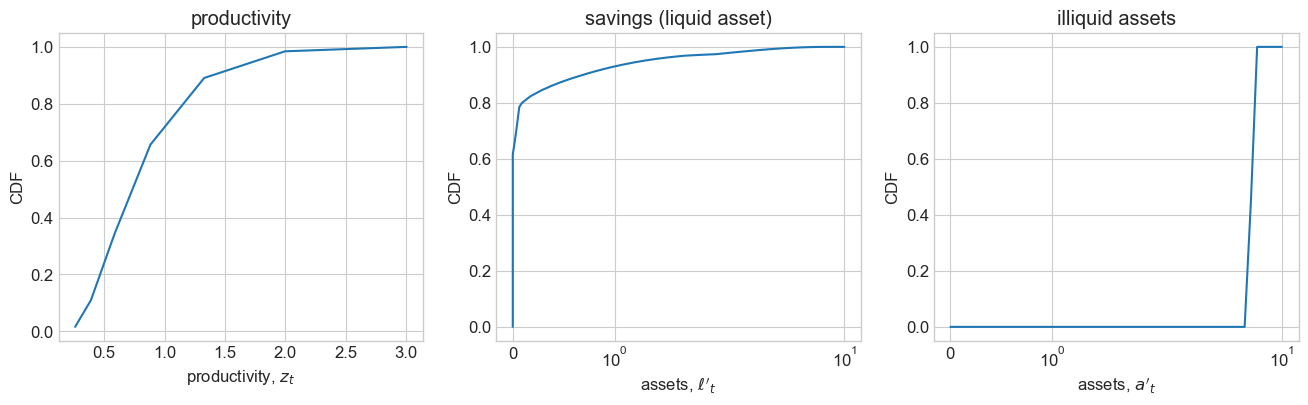

In [21]:
fig = plt.figure(figsize=(16,4),dpi=100)

# a. income
ax = fig.add_subplot(1,3,1)
ax.set_title('productivity')
ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2,3))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. liquid assets
ax = fig.add_subplot(1,3,2)
ax.set_title('savings (liquid asset)')
ax.plot(np.insert(par.l_grid,0,par.l_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,3))),0,0.0),label='discrete')
ax.set_xlabel('assets, $\ell\'_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. illiquid assets
ax = fig.add_subplot(1,3,3)
ax.set_title('illiquid assets')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,2))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a\'_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

In [22]:
# Expected illiquid asset holdings
E_a = (a*ss.D).sum()
print(f'Expected Assets minus target = {E_a - ss.A:.3e}')
d_i_a_target = (ss.D).sum(axis=(0,1,2))[i_a_target]
d_i_a_target_p1 = (ss.D).sum(axis=(0,1,2))[i_a_target+1]
print(f'weight at illiquid asset grids to both sides of the target: {d_i_a_target:.4f} and {d_i_a_target_p1:.4f}, sum {d_i_a_target+d_i_a_target_p1:.4f}')

Expected Assets minus target = 5.507e-14
weight at illiquid asset grids to both sides of the target: 0.4474 and 0.5526, sum 1.0000


In [23]:
# # distribution along liquid asset grid
# D_l = ss.D.sum(axis=(0,1,3))
# C_d = np.cumsum(np.sum(ss.D,axis=(0,1,3)))
# C_d_diff = np.hstack((C_d[0],C_d[1:] - C_d[:-1]))
# df_C_d = pd.DataFrame(np.vstack((par.l_grid, C_d, C_d_diff)).T)
# C_d_diff

array([6.14974777e-01, 4.75560991e-02, 5.59180276e-02, 6.65611953e-02,
       1.39223473e-02, 8.04660929e-03, 8.40049081e-03, 8.44289890e-03,
       6.47211284e-03, 7.13377381e-03, 7.85014224e-03, 6.48014447e-03,
       7.52703319e-03, 7.14433374e-03, 7.47976124e-03, 7.35261890e-03,
       7.42741374e-03, 7.55841782e-03, 7.98282740e-03, 8.02951617e-03,
       8.02422951e-03, 7.93816767e-03, 7.78896483e-03, 7.54795884e-03,
       7.12757887e-03, 6.62847537e-03, 5.90162015e-03, 5.11318232e-03,
       3.00281559e-03, 2.64515268e-03, 2.48215622e-03, 2.40096688e-03,
       2.29730181e-03, 2.20604919e-03, 2.16666413e-03, 2.08800030e-03,
       1.96482059e-03, 1.83094256e-03, 1.68482397e-03, 1.52540193e-03,
       1.35225064e-03, 1.16583830e-03, 9.67909925e-04, 7.62035378e-04,
       5.54375360e-04, 3.54727269e-04, 1.81505131e-04, 3.55439899e-05,
       0.00000000e+00, 0.00000000e+00])

### MPCs

In [24]:
# for liquid assets
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:, :, 1:, :] - ss.c[:, :, :-1, :])
l_grid_full = np.repeat(par.l_grid, par.Na).reshape(1,1,par.Nl,par.Na)
dl = (1 + ss.rl) * l_grid_full[:, :, 1:, :] - (1 + ss.rl) * l_grid_full[:, :, :-1, :]
MPC[:, :, :-1, :] = dc / dl
MPC[:, :, -1, :] = MPC[:, :, -2, :]  # assuming constant MPC at end
mean_MPC = np.sum(MPC * ss.D)
# mean_MPC_ann = 1 - (1 - mean_MPC) ** 4
# print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')
print(f'mean MPC out of liquid assets: {mean_MPC:.3f} (annual terms)')

mean MPC out of liquid assets: 0.503 (annual terms)


In [25]:
# for illiquid assets
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:, :, :, 1:] - ss.c[:, :, :, :-1])
a_grid_full = par.a_grid.reshape(1,1,1, par.Na).repeat(par.Nl,2)
# a_grid_full = np.repeat(par.a_grid, par.Nl).reshape(1,1,par.Nl,par.Na).swapaxes(2,3)
da = (1 + ss.ra) * a_grid_full[:, :, :, 1:] - (1 + ss.ra) * a_grid_full[:, :, :, :-1]
MPC[:, :, :, :-1] = dc / da
MPC[:, :, :, -1] = MPC[:, :, :, -2]  # assuming constant MPC at end
mean_MPC = np.sum(MPC * ss.D)
# mean_MPC_ann = 1 - (1 - mean_MPC) ** 4
# print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')
print(f'mean MPC out of illiquid assets: {mean_MPC:.3f} (annual terms)')

mean MPC out of illiquid assets: 0.019 (annual terms)


# Step 2: Compute Jacobians (incl. tests)

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.3 secs
household problem simulated along transition in 1.4 secs



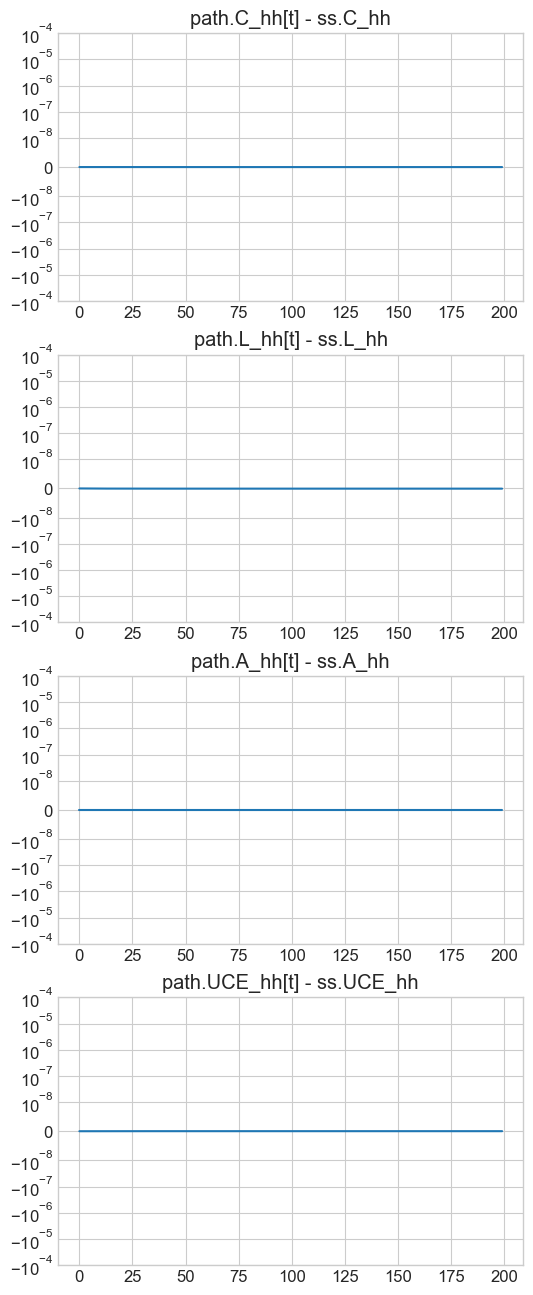

In [26]:
model.test_hh_path()

**Full transition path:**

In [27]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
clearing_A     : t0 =  0.0e+00, max abs.  0.0e+00
clearing_L     : t0 = -2.8e-17, max abs.  2.8e-17
clearing_C     : t0 = -7.2e-12, max abs.  7.2e-12
clearing_Y     : t0 =  0.0e+00, max abs.  0.0e+00
clearing_fund_start: t0 =  5.5e-14, max abs.  5.5e-14
clearing_fund_end: t0 = -5.5e-14, max abs.  5.5e-14
Div_int        : t0 = -1.1e-16, max abs.  1.1e-16
Div_k          : t0 =  6.9e-18, max abs.  6.9e-18
Div            : t0 =  0.0e+00, max abs.  0.0e+00
eg             : t0 =  0.0e+00, max abs.  0.0e+00
em             : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
I              : t0 =  0.0e+00, max abs.  0.0e+00
Ip             : t0 =  0.0e+00, max abs.  0.0e+00
K            

In [28]:
# import os
# from HANKStickyModel import HANKStickyModelClass
# # model.save()
# savefolder = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models')
# model = HANKStickyModelClass(name='baseline', savefolder=savefolder)
# model.load()

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 20 50 [computed in 1.0 secs]
finding Jacobian wrt. Z              : 0 20 50 [computed in 1.0 secs]
finding Jacobian wrt. ra             : 0 20 50 [computed in 1.0 secs]
finding Jacobian wrt. rl             : 0 20 50 [computed in 1.0 secs]
household Jacobian computed in 4.3 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Z               in 0.7 secs
curly_Y and curly_D calculated for ra              in 0.7 secs
curly_Y and curly_D calculated for rl              in 0.7 secs
curly_E calculated in 1.9 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 4.1 secs

C_hh:
 Z              : cond = 2.5e+00 [mean =  4.9e-03]
 ra             : cond = 3.4e+03 [mean =  4.5e-02]
 rl             : cond = 3.3e+01 [mean =  5.7e-04]

L_hh:
 Z              : cond = 8.0e+00 [mean =  2.6e-03]
 ra         

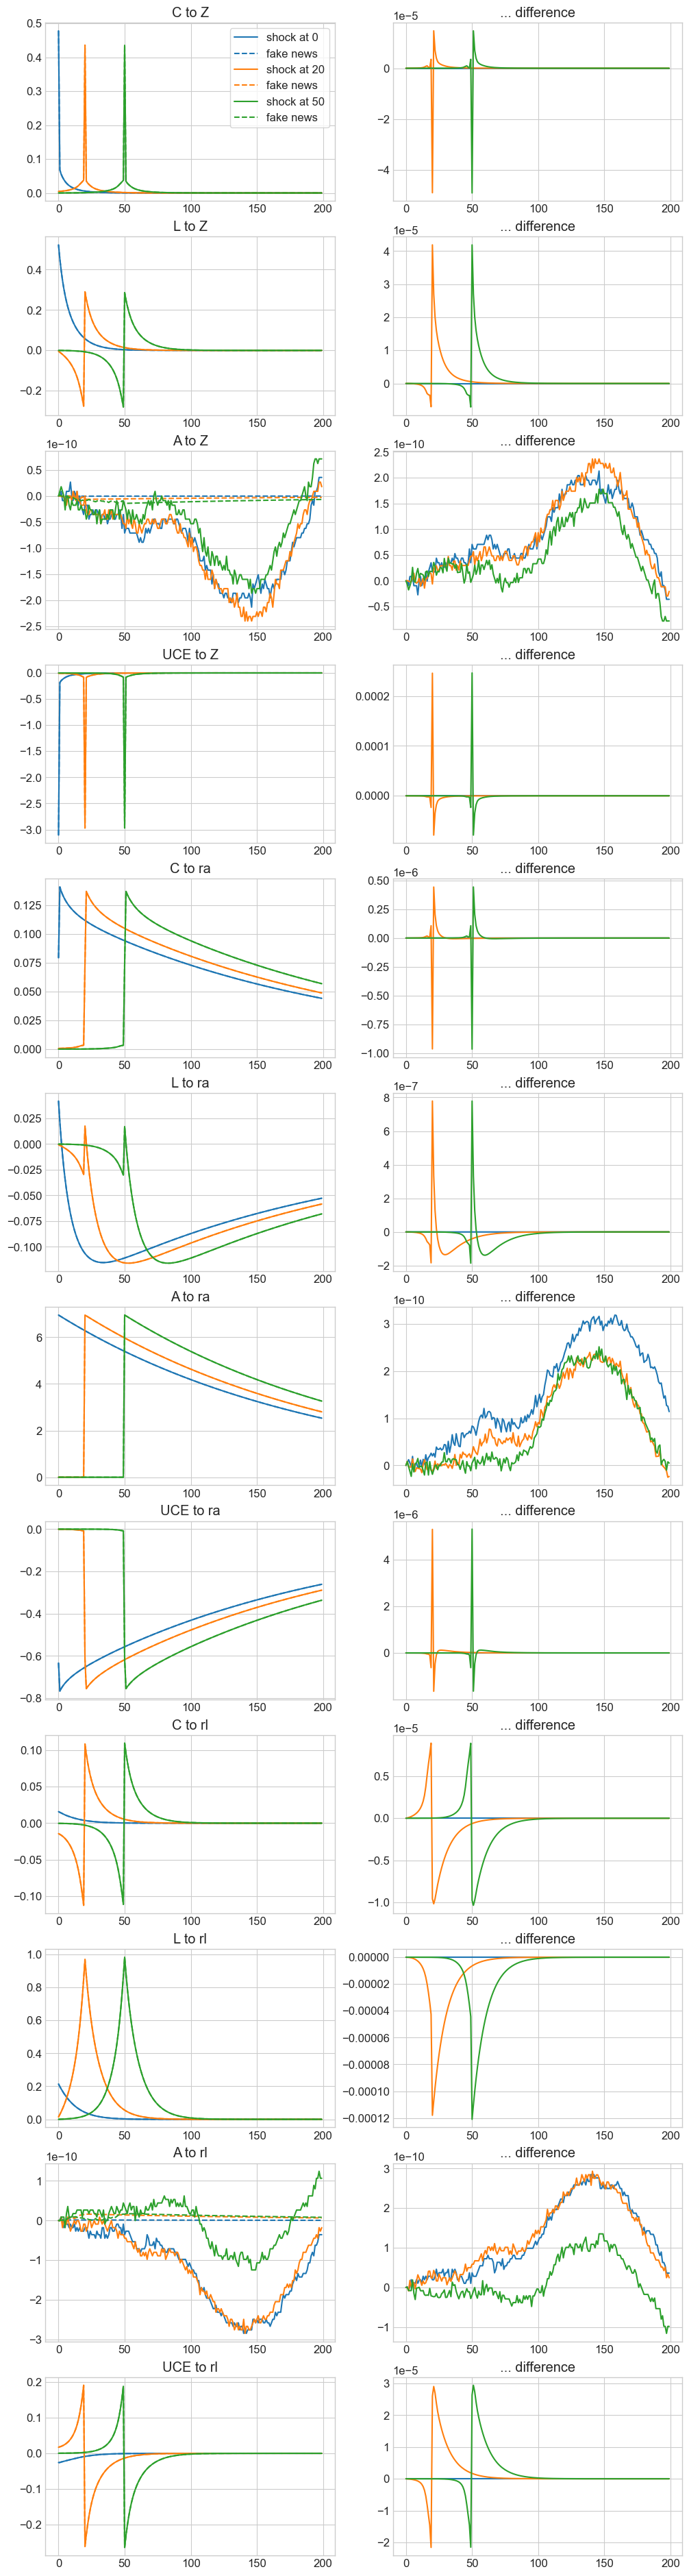

In [29]:
model.test_jacs(s_list=[0,20,50])

# Step 3a: Find non-linear transition_path

In [30]:
# model.par.tol_broyden = 1e-5
model.find_transition_path(do_print=True, do_print_unknowns=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.50e-04
   r              : minval =   0.012 meanval =   0.012 maxval =   0.012
   w              : minval =   0.886 meanval =   0.886 maxval =   0.886
   Y              : minval =   1.000 meanval =   1.000 maxval =   1.000
   Ip             : minval =   0.030 meanval =   0.030 maxval =   0.030
   Q              : minval =   1.000 meanval =   1.000 maxval =   1.000
   2.50e-04 in fisher_res
   7.86e-16 in w_res
   7.21e-12 in clearing_Y
   0.00e+00 in invest_res
   0.00e+00 in valuation_res
 it =   1 -> max. abs. error = 1.96e+03
   r              : minval =  -0.007 meanval =   0.014 maxval =   0.043
   w              : minval =   0.812 meanval =   0.891 maxval =   1.064
   Y              : minval =   0.989 meanval =   1.002 maxval =   1.084
   Ip             : minval =  -0.005 meanval =   0.028 maxval =   0.041
   Q              : minval =   0.788 meanval =   0.991 maxval =   1.078
   5.47e-02 in fisher_res
   2.71e-01 in w_

ValueError: GEModelTools: No convergence after 100 iterations with broyden_solver(tol=1.0e-10)

In [ ]:
model.find_IRFs(do_print=True)

**Results:** We now have

1. The transition path of all variables, `path.VARNAME[0,:]`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[0,t] == np.sum(path.a[t]*path.D[t])`.

In [ ]:
for outputname in model.outputs_hh:
    Outputname_hh = f'{outputname.upper()}_hh'
    diff = path.__dict__[Outputname_hh][0,:]-np.sum(path.__dict__[outputname]*path.D,axis=(1,2,3,4))
    max_abs_diff = np.max(np.abs(diff))
    print(f'{Outputname_hh}: {max_abs_diff = }')

## Plot transitions

### MP shock shock

In [ ]:
# replication_settings = {'do_replicate': {}}
# replication_settings['do_replicate']['plot_em'] = True
paths = ['G', 'Y', 'C_hh', 'K', 'I',
         'N', 'w', 'tau', 'Pi', 'Pi_w', 'i', 's', 's_w', 'Z',
         'L_hh', 'A_hh',
         'rk', 'r','ra', 'rl',
         'q', 'B',
         'p_eq', 'Div', 'p_int', 'Div_int', 'p_k', 'Div_k']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100}

In [ ]:
if replication_settings['do_replicate']['plot_em']:
    shock_settings = {
                'jump_em': 0.00025,
                'rho_em': 0.6,
                'jump_eg': 0.
            }
    model.par.jump_em = shock_settings['jump_em']
    model.par.rho_em = shock_settings['rho_em']
    model.par.jump_eg = shock_settings['jump_eg']
    model.find_transition_path(do_end_check=False)
    model.find_IRFs()
    paths_short2 = ['Y', 'C_hh', 'L_hh', 'I', 'K', 'Q', 'r', 'rk', 'ra', 'rl']
    abs_diff2 = ['Y', 'C_hh', 'L_hh', 'I', 'psi', 'r']
    model.show_IRFs(paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=200, do_linear=True, do_shocks=True)

In [ ]:
path = model.path
ss = model.ss
par = model.par

In [ ]:
A_lag = ss.A_hh
term_L = (1 + ss.rl) * ss.L_hh + par.xi * ss.L_hh
term_B = (1 + par.delta_q * path.q[0,0]) * ss.B
term_eq = path.p_eq[0,0] + path.Div[0,0]

ra = (term_B + term_eq - term_L) / A_lag - 1
d_ra = (ra - ss.ra)
print(f"ra changes by {d_ra} ")

In [ ]:
q_new = ss.q + ss.q * 0.01
term_B = (1 + par.delta_q * q_new) * ss.B
term_eq = ss.p_eq + ss.Div

ra = (term_B + term_eq - term_L) / A_lag - 1
d_ra = (ra - ss.ra)
print(f"ra changes by {d_ra} if q increases by 1 percent")

p_eq_new = ss.p_eq + 0.01 * ss.p_eq
term_B = (1 + par.delta_q * ss.q) * ss.B
term_eq = p_eq_new + ss.Div

ra = (term_B + term_eq - term_L) / A_lag - 1
d_ra = (ra - ss.ra)
print(f"ra changes by {d_ra} if p_eq increases by 1 percent")

Div_eq_new = ss.Div + 0.01 * ss.Div
term_B = (1 + par.delta_q * ss.q) * ss.B
term_eq = ss.p_eq + Div_eq_new

ra = (term_B + term_eq - term_L) / A_lag - 1
d_ra = (ra - ss.ra)
print(f"ra changes by {d_ra} if Div increases by 1 percent")


In [ ]:
d_p_eq = ((ss.Div + ss.p_eq) / (1 + ss.r + 0.01 * ss.r) - ss.p_eq) / ss.p_eq
print(f"p_eq changes by {d_p_eq} percent if r increases by 1 percent")
print(f"in absolute terms: {d_p_eq * ss.p_eq}")

In [ ]:
A_hh_lag = np.hstack([ss.A_hh, path.A_hh[0, :-1]])
L_hh_lag = np.hstack([ss.L_hh, path.L_hh[0, :-1]])
B_lag = np.hstack([ss.B, path.B[0, :-1]])

# beginning of period constraint
LHS = (1 + path.ra[0]) * A_hh_lag + (1 + path.rl[0]) * L_hh_lag
RHS = (1 + par.delta_q * path.q[0]) * B_lag+ path.p_eq[0] + path.Div[0] - par.xi * L_hh_lag
LHS - RHS

### Fisal Policy shock

In [ ]:
print(f'Fraction of debt financing of the shock: {par.phi_G * 100}%')

In [ ]:
shock_settings = {
                'jump_em': 0.,
                'rho_eg': 0.6,
                'jump_eg': 0.01
            }
model.par.jump_em = shock_settings['jump_em']
model.par.rho_eg = shock_settings['rho_eg']
model.par.jump_eg = shock_settings['jump_eg']

In [ ]:
paths = ['G', 'Y', 'C_hh', 'K', 'I',
         'N', 'w', 'tau', 'Pi', 'Pi_w', 'i', 's', 's_w',
         'L_hh', 'A_hh',
         'rk', 'r','ra', 'rl',
         'q', 'B',
         'p_eq', 'Div', 'p_int', 'Div_int', 'p_k', 'Div_k']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100}
# model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100)
model.find_transition_path(do_end_check=False)
model.find_IRFs()
model.show_IRFs(paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100, do_linear=True, do_shocks=True)

    # Compare other models

### tax vs deficit financing

In [ ]:
if replication_settings['do_replicate']['compare_tax_debt']:
    models = {
        'tax_financing': {      # this is the baseline model
        },
        'deficit_financing': {  # deficit financing but repayment over time
            'update_par':{
                'phi_G': 1.0
            },
        }
    }

    shock_settings = {
                'jump_em': 0.,
                'rho_eg': 0.6,
                'jump_eg': 0.01
            }

    compare_models = {'tax_financing': models['tax_financing'],
                      'deficit_financing': models['deficit_financing']}
    # create other models to be analyzed
    # init containter for models
    models_solved = {}
    for m, m_keys in compare_models.items():
        # init model
        print(f'Model: {m}')
        if 'update_par' in m_keys.keys():
            updated_par = {**replication_settings['update_par'], **m_keys['update_par']}
        else:
            updated_par = replication_settings['update_par']
        models_solved[m] = HANKStickyModelClass(name=m, par=updated_par)
        # solve model
        models_solved[m].find_ss(do_print=False)
        models_solved[m].compute_jacs(do_print=False)

        models_solved[m].par.jump_em = shock_settings['jump_em']
        models_solved[m].par.rho_eg = shock_settings['rho_eg']
        models_solved[m].par.jump_eg = shock_settings['jump_eg']

        models_solved[m].find_transition_path(do_print=False, do_print_unknowns=False)
        models_solved[m].find_IRFs(do_print=False)

    labels_list = list(models_solved.keys())
    models_list = list(models_solved.values())

    from GEModelTools import GEModelClass
    GEModelClass.compare_IRFs(models_list, labels_list, paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100)
